In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline



# Load data
df = pd.read_csv("companies.csv")
print (df.head(2))


# Get details on data
print("\nGet details on data")
print(df.info())

# View shape of data
print("\nShape of data")
print(df.shape)

  company  04-01-10  05-01-10  06-01-10  07-01-10  08-01-10  11-01-10  \
0   Apple  0.580000 -0.220005 -3.409998     -1.17  1.680011 -2.689994   
1     AIG -0.640002 -0.650000 -0.210001     -0.42  0.710001 -0.200001   

   12-01-10  13-01-10  14-01-10  ...  16-10-13  17-10-13  18-10-13  21-10-13  \
0 -1.469994  2.779997 -0.680003  ...  0.320008  4.519997  2.899987  9.590019   
1 -1.130001  0.069999 -0.119999  ...  0.919998  0.709999  0.119999 -0.480000   

   22-10-13  23-10-13  24-10-13  25-10-13  28-10-13   29-10-13  
0 -6.540016  5.959976  6.910011 -5.359962  0.840019 -19.589981  
1  0.010002 -0.279998 -0.190003 -0.040001 -0.400002   0.660000  

[2 rows x 964 columns]

Get details on data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 964 entries, company to 29-10-13
dtypes: float64(963), object(1)
memory usage: 452.0+ KB
None

Shape of data
(60, 964)



Missing values...
company     0
04-01-10    0
05-01-10    0
06-01-10    0
07-01-10    0
           ..
23-10-13    0
24-10-13    0
25-10-13    0
28-10-13    0
29-10-13    0
Length: 964, dtype: int64


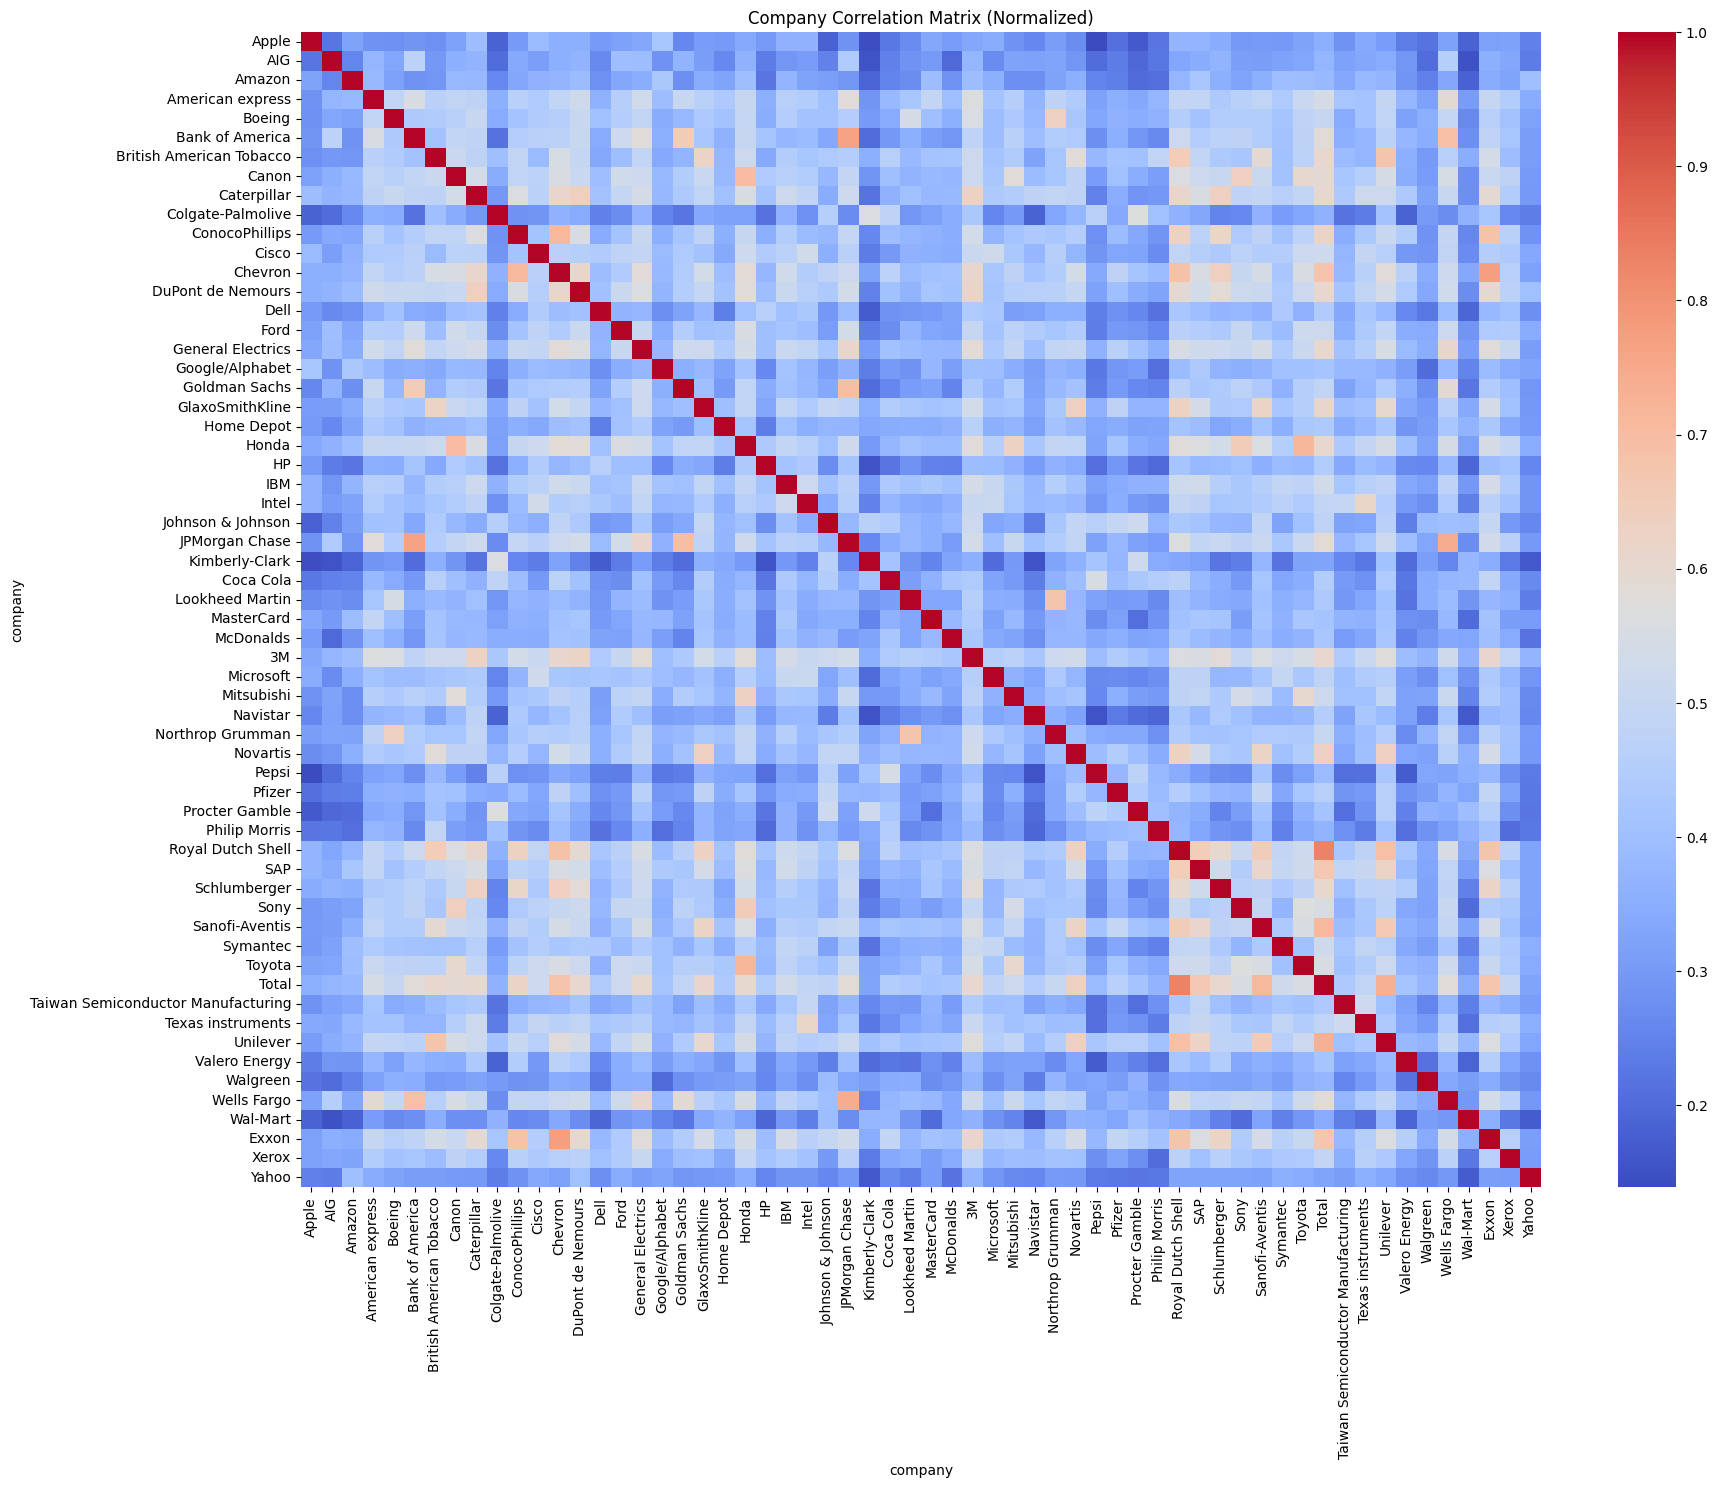

In [117]:
# Phase 1 : PREPROCESSING & CORRELATION
# Check for missing values
print("\nMissing values...")
print(df.isna().sum())

# Drop names column from df
data = df.drop("company", axis=1).values

# Normalize data
# Initiate normalizer
normalizer = Normalizer()

# Create a DataFrame of normalized movements
normalized_movements = normalizer.fit_transform(data)
norm_df = pd.DataFrame(normalized_movements, index=df['company'])

# Calculate the correlation matrix 
# Transpose (.T) because .corr() compares columns (companies)
corr_matrix = norm_df.T.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Company Correlation Matrix (Normalized)')
plt.show()         


Shape of movements...
(60, 2)

Labels...
[7 4 7 9 2 0 3 9 0 1 5 4 5 9 4 4 9 7 0 3 6 0 4 2 4 8 0 1 8 6 2 6 9 4 9 4 2
 3 1 8 1 8 5 9 0 0 3 4 9 5 4 4 3 9 6 0 1 3 4 7]


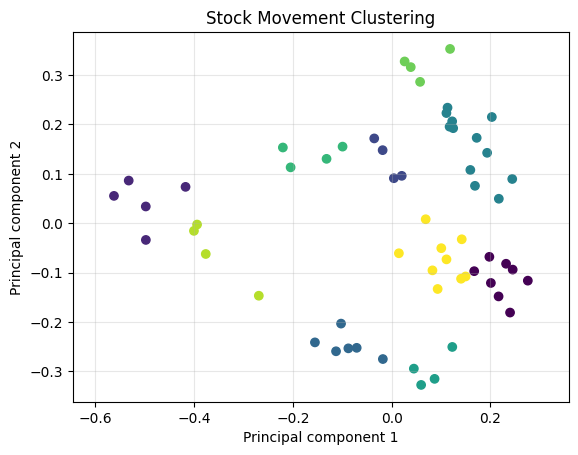

In [118]:
# Phase 2 : EXPLORATION (PCA & ELBOW)
from sklearn.decomposition import PCA

# Create PCA component:pca
pca = PCA(n_components=2)


# Fit movements to PCA and transform
movements = pca.fit_transform(normalizer.transform(data))
print("\nShape of movements...")
print(movements.shape)

# Create a KMeans model with 10 clusters
model = KMeans(n_clusters=10)

# Fit to model
model.fit(movements)

# Predict clusters
labels = model.predict(movements)
print("\nLabels...")
print(labels)


# Visualise PCA transformation
# Assign 0th column of pca_features: xs
xs = movements[:,0]

# Assign 1th column of pca_features: ys
ys = movements[:,1]


# Scatter plot xs vs ys
plt.title('Stock Movement Clustering')
plt.scatter(xs, ys, c=labels)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

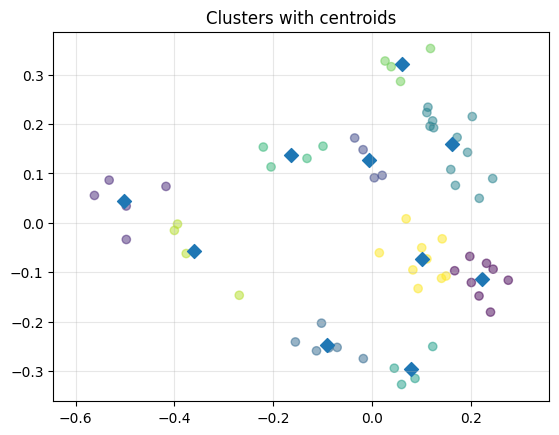

In [119]:
# Inspect clustering
# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs, ys, c=labels, alpha=0.5)

# Assign the cluster centers: centroids
centroids = model.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x, centroids_y, marker='D', s=50)
plt.title("Clusters with centroids")
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

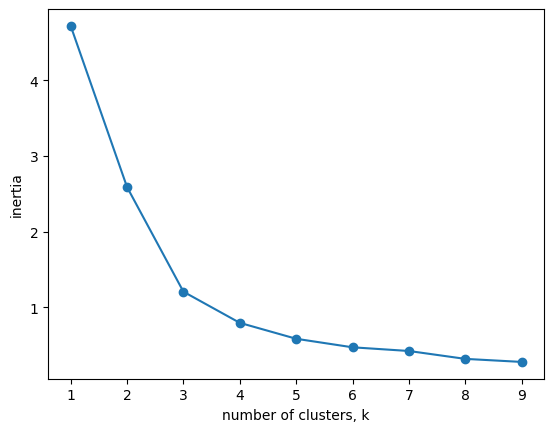

In [120]:
# Hyperparameter Tuning
# Find the optimal number of clusters  using inertia: k
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans model instance with k clusters: model
    model = KMeans(n_clusters = k)

    # Fit model to movements
    model.fit(movements)

    #Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [121]:
# Phase 3:PRODUCTION PIPELINE
# Create a KMeans model with 4 clusters from ineartia plot
kmeans = KMeans(n_clusters=4, random_state=42)

# Build the pipeline
pipeline = make_pipeline(normalizer, kmeans)
pipeline.fit(data)

# Predict new clusters
labels = pipeline.predict(data)
print(labels)

[2 2 2 3 2 3 3 3 2 1 2 3 3 2 0 2 3 2 3 3 1 3 0 3 3 1 3 1 1 2 2 1 2 3 3 2 2
 3 1 1 1 1 3 3 2 3 3 3 3 3 2 2 3 2 1 3 1 3 3 2]


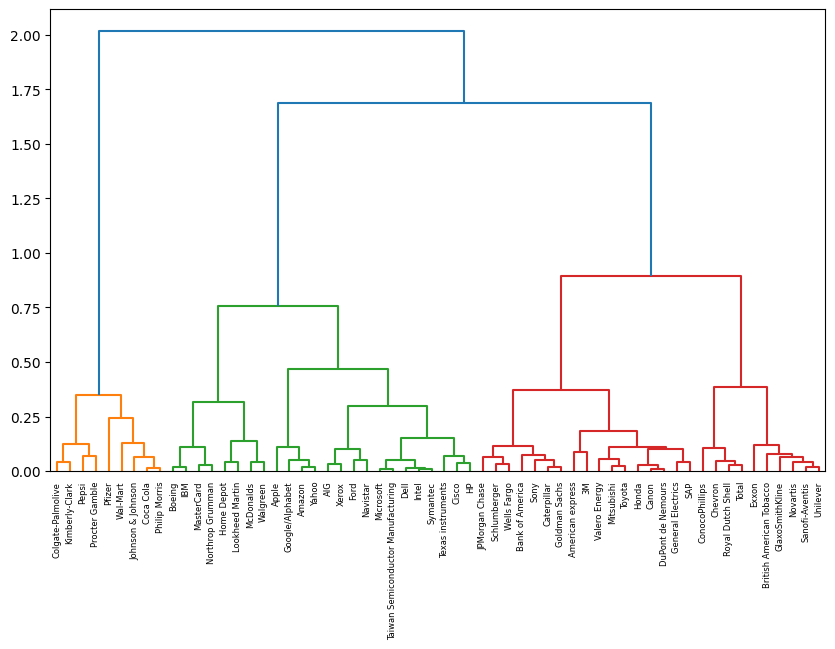

In [122]:
# Phase 4: VISUALIZATION & INTERPRETATION

# Visualise Hierarchical Clustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import normalize


# Calculate the linkage: mergings
mergings = linkage(movements, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(mergings,
           labels=df['company'].values,
           leaf_rotation=90,
           leaf_font_size=6
          )
plt.show()

In [123]:
companies = df['company']

# Create a DataFrame aligning labels and companies: df
df_new = pd.DataFrame({'labels': labels, 'companies': companies})

# Display df_new sorted by cluster label
print(df_new.sort_values('labels'))

    labels                           companies
14       0                                Dell
22       0                                  HP
31       1                           McDonalds
9        1                   Colgate-Palmolive
25       1                   Johnson & Johnson
27       1                      Kimberly-Clark
20       1                          Home Depot
28       1                           Coca Cola
40       1                      Procter Gamble
41       1                       Philip Morris
54       1                            Walgreen
56       1                            Wal-Mart
39       1                              Pfizer
38       1                               Pepsi
15       2                                Ford
13       2                   DuPont de Nemours
30       2                          MasterCard
29       2                     Lookheed Martin
17       2                     Google/Alphabet
32       2                                  3M
59       2   

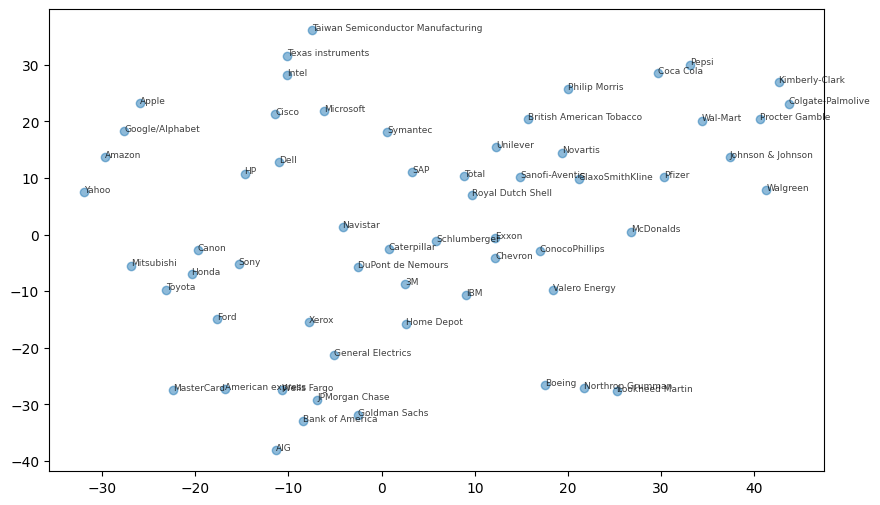

In [124]:
# ADVANCED VISUALIZATION (t-SNE)
# Visualise with t-SNE (t-Distributed Stochastic Neighbor Embedding)
from sklearn.manifold import TSNE


# Create a TSNE instance: model
model = TSNE(learning_rate=50, perplexity=10)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(normalizer.transform(data))

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1th feature: ys
ys = tsne_features[:,1]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(xs, ys, alpha=0.5)

# Annotate the points
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x, y), fontsize=6.5, alpha=0.75)
plt.show()